## Hyphothesis 4a: 
### The Alternative Portfolio will outperform Control Portfolio 1 and Control Portfolio 2 the 5 worst S&P500 days in 2019

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import random
import seaborn as sns
import scipy
from scipy.stats import levene
from scipy.stats import ttest_ind
import scipy.stats as stats
from time import time


os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')

In [3]:
%matplotlib notebook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Import Price/Returns Data

In [4]:
df_price = pd.read_csv('data\\processed\\df_price07_20.csv')
df_return = pd.read_csv('data\\processed\\df_return7_20.csv')

df_price.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_return.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

df_price.index = pd.to_datetime(df_price['date'])
df_return.index = pd.to_datetime(df_return['date'])

df_price = df_price.drop('date', axis=1)
df_return = df_return.drop('date', axis=1)


sp_price = df_price['SPX']
sp_return = df_return['SPX']

df_price = df_price.drop('SPX', axis=1)
df_return = df_return.drop('SPX', axis=1)



df_price18 = df_price[df_price.index<='2018-12-31'].sort_index()
df_price19 = df_price[(df_price.index>'2018-12-31') & (df_price.index<='2019-12-31')].sort_index()

df_return18 = df_return[df_return.index<='2018-12-31'].sort_index()
df_return19 = df_return[(df_return.index>'2018-12-31') & (df_return.index<='2019-12-31')].sort_index()


sp_return18 = sp_return[sp_return.index<='2018-12-31'].sort_index()
sp_return19 = sp_return[(sp_return.index>'2018-12-31')&(sp_return.index<='2019-12-31')].sort_index()

In [5]:
full_companies = df_price.columns

### Find the dates of the worst trading days systemically & by the company

In [6]:
dates19 = df_price19.index

#### RETURNS: 5 worst Return dates: S&P (2007-2018)

In [7]:
worst_dates_sp18 = sp_return18.sort_values()[:5].sort_index()
worst_dates_sp18

date
2008-09-29   -0.084900
2008-10-09   -0.079420
2008-10-15   -0.087231
2008-11-20   -0.066301
2008-12-01   -0.081476
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: S&P 2019

In [8]:
worst_dates_sp19 = sp_return19.sort_values()[:5].sort_index()
worst_dates_sp19

date
2019-01-03   -0.017669
2019-03-22   -0.015402
2019-08-05   -0.018402
2019-08-14   -0.018503
2019-08-23   -0.021971
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2007-2018)

In [9]:
worst_days_returns18 = {}
for symbol in full_companies:
    temp_series = df_return18[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns18[symbol] = temp_series
worst_days_returns18['ORCL']

date
2007-11-08   -0.070776
2008-09-29   -0.077188
2008-10-07   -0.082559
2008-10-14   -0.085315
2008-10-15   -0.083333
Name: ORCL, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2019)

In [10]:
worst_days_returns19 = {}
for symbol in full_companies:
    temp_series = df_return19[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns19[symbol] = temp_series
worst_days_returns19['ORCL']

date
2019-03-20   -0.023195
2019-05-28   -0.025057
2019-07-31   -0.027298
2019-08-05   -0.024319
2019-08-23   -0.027893
Name: ORCL, dtype: float64

### Generate DF 5 Worst Dates + 1 Day Behind

In [11]:
dates_back1 = []
for idx in range(1, len(dates19)):
    #print(idx)
    dates_back1.append(dates19[idx-1])
dates_back1 = pd.to_datetime(dates_back1)
df_day_behind1 = pd.DataFrame(dates_back1, index=dates19[1:], columns=['Day Behind 1'])
df_day_behind1.head()

,Day Behind 1
date,
2019-01-03,2019-01-02
2019-01-04,2019-01-03
2019-01-07,2019-01-04
2019-01-08,2019-01-07
2019-01-09,2019-01-08


In [12]:
day_behind_dates = pd.merge(df_day_behind1, worst_dates_sp19, left_index=True, right_index=True)['Day Behind 1'].values
day_behind_dates

array(['2019-01-02T00:00:00.000000000', '2019-03-21T00:00:00.000000000',
       '2019-08-02T00:00:00.000000000', '2019-08-13T00:00:00.000000000',
       '2019-08-22T00:00:00.000000000'], dtype='datetime64[ns]')

## $$For\thinspace each\thinspace  Date\thinspace  in\thinspace  the\thinspace  5\thinspace  Worst\thinspace Dates\thinspace of\thinspace 2019\thinspace$$ <br> $$H^{1}_{0}: \mu_{alt} = \mu_{ctl1} \hspace{1cm} H^{1}_{A}: \mu_{alt} > \mu_{ctl1}$$<br><br>$$H^{2}_{0}: \mu_{alt} = \mu_{ctl2} \hspace{1cm} H^{2}_{A}: \mu_{alt} > \mu_{ctl2}$$

In [23]:
n_loops = 10000
experiment_df = pd.DataFrame([])
t0 = time()

for value in range(n_loops):
    alt_list = []
    ctl_list1 = []
    for symbol in full_companies:
        temp_series = worst_days_returns18[symbol]
        temp_dates = temp_series.index
        temp_val = 0
        for date in temp_dates:
            #if (date >= pd.to_datetime('2008-09-01')) and (date <= pd.to_datetime('2008-12-31')):
            if date in worst_dates_sp18.index:            
                temp_val +=1
        if temp_val==0:
            alt_list.append(symbol)
        else:
            ctl_list1.append(symbol)

    alt_symbols = random.sample(alt_list, 25)
    control_symbols1 = random.sample(ctl_list1, 25)
    control_symbols2 = random.sample(list(full_companies), 25)       


    ### Alternative
    alt18 = df_price18.loc[:, alt_symbols]
    alt19 = df_price19.loc[:, alt_symbols]
    con181 = df_price18.loc[:, control_symbols1]
    con191 = df_price19.loc[:, control_symbols1]
    con182 = df_price18.loc[:, control_symbols2]
    con192 = df_price19.loc[:, control_symbols2]

    worst_days_alt_portfolio19 = pd.concat([alt19.loc[worst_dates_sp19.index, :], alt19.loc[day_behind_dates, :]]).sort_index()
    worst_days_ctl1_portfolio19 = pd.concat([con191.loc[worst_dates_sp19.index, :], con191.loc[day_behind_dates, :]]).sort_index()
    worst_days_ctl2_portfolio19 = pd.concat([con192.loc[worst_dates_sp19.index, :], con192.loc[day_behind_dates, :]]).sort_index()

    alt_values_worst_days19 = worst_days_alt_portfolio19.apply(sum, axis=1)
    ctl1_values_worst_days19 = worst_days_ctl1_portfolio19.apply(sum, axis=1)
    ctl2_values_worst_days19 = worst_days_ctl2_portfolio19.apply(sum, axis=1)


    comparison_dic = {}
    temp_experiment = pd.DataFrame([])
    idx=0
    for i in range(10):
        if i % 2 == 0:
            pass
        else:
            temp_idx = alt_values_worst_days19.index[i]        
            temp_sp = worst_dates_sp19[worst_dates_sp19.index==temp_idx].values[0]

            temp_start_ctl1 = ctl1_values_worst_days19[i-1]
            temp_start_ctl2 = ctl2_values_worst_days19[i-1]        
            temp_start_alt = alt_values_worst_days19[i-1]

            temp_end_ctl1 = ctl1_values_worst_days19[i]
            temp_end_ctl2 = ctl2_values_worst_days19[i]        
            temp_end_alt = alt_values_worst_days19[i]        

            temp_ret_ctl1 = (temp_end_ctl1-temp_start_ctl1)/temp_end_ctl1
            temp_ret_ctl2 = (temp_end_ctl2-temp_start_ctl2)/temp_end_ctl2        
            temp_ret_alt = (temp_end_alt-temp_start_alt)/temp_end_alt        
            #print(temp_end, temp_start)

            comparison_dic['date'] = temp_idx       
            comparison_dic['SPX'] =  temp_sp
            comparison_dic['CTL1'] = temp_ret_ctl1
            comparison_dic['CTL2'] = temp_ret_ctl2        
            comparison_dic['ALT'] = temp_ret_alt
            comparison_dic['sample'] = value+1
            temp_df = pd.DataFrame([comparison_dic])
            temp_experiment = pd.concat([temp_experiment, temp_df])

    experiment_df = pd.concat([experiment_df, temp_experiment])
    if value % 500 == 0:
        t1 = time()  
        print('{} minutes have passed'.format(round((t1-t0)/60, 4)))

print('finished')
experiment_df = experiment_df.sort_values(by=['date', 'sample'])
experiment_df.head(1)

0.0013 minutes have passed
0.5079 minutes have passed
1.0186 minutes have passed
1.4937 minutes have passed
1.997 minutes have passed
2.4687 minutes have passed
2.9379 minutes have passed
3.4404 minutes have passed
4.1032 minutes have passed
4.7778 minutes have passed
5.3966 minutes have passed
6.043 minutes have passed
6.6676 minutes have passed
7.3427 minutes have passed
7.9855 minutes have passed
8.615 minutes have passed
9.3183 minutes have passed
9.9696 minutes have passed
10.7171 minutes have passed
11.4012 minutes have passed
finished


,date,SPX,CTL1,CTL2,ALT,sample
0,2019-01-03,-0.017669,-0.032758,-0.0396,-0.017109,1


In [30]:
alpha=0.05
z_critical = 1.645
hypothesis_df = pd.DataFrame([])

for date in worst_dates_sp19.index:
    temp_dic = {}
    temp_df = experiment_df[experiment_df['date']==date]
    temp_ctl1 = temp_df['CTL1'] 
    temp_ctl2 = temp_df['CTL2'] 
    temp_alt = temp_df['ALT']

    ### Z - Test
    x_bar_alt = temp_alt.mean()
    x_bar_ctl1 = temp_ctl1.mean()
    x_bar_ctl2 = temp_ctl2.mean()
    std_error1 = np.sqrt(temp_alt.var()+temp_ctl1.var()-2*np.cov(temp_alt, temp_ctl1)[0][1])
    std_error2 = np.sqrt(temp_alt.var()+temp_ctl2.var()-2*np.cov(temp_alt, temp_ctl2)[0][1])    
    z_hat1 = (x_bar_alt-x_bar_ctl1)/std_error1
    z_hat2 = (x_bar_alt-x_bar_ctl2)/std_error2    
    ## Generate P-values
    p1 = 1-stats.norm.cdf(z_hat1)
    p2 = 1-stats.norm.cdf(z_hat2)
    
    ### Generate Upper/Lower Bounds
    t_lower1 = x_bar_alt-std_error1*z_critical
    t_lower2 = x_bar_alt-std_error2*z_critical    
    t_upper1 = x_bar_alt+std_error1*z_critical
    t_upper2 = x_bar_alt+std_error2*z_critical    

    ### Append Dataframe
    temp_dic['Check Date'] = date    
    temp_dic['x_bar_alt'] = x_bar_alt 
    temp_dic['lower1'] = t_lower1
    temp_dic['upper1'] = t_upper1
    temp_dic['P1A'] = p1
    temp_dic['H1A'] = ['Reject' if p1 < alpha else 'Accept']    
    temp_dic['lower2'] = t_lower2
    temp_dic['upper2'] = t_upper2
    temp_dic['P2A'] = p2
    temp_dic['H2A'] = ['Reject' if p2 < alpha else 'Accept']
    
    temp_df = pd.DataFrame(temp_dic)
    hypothesis_df = pd.concat([hypothesis_df, temp_df])

hypothesis_df.to_csv('plots\\h4a\\hypothesis_test_s10000_1.csv') 
hypothesis_df        

,Check Date,x_bar_alt,lower1,upper1,P1A,H1A,lower2,upper2,P2A,H2A
0,2019-01-03,-0.019118,-0.029429,-0.008807,0.339020,Accept,-0.029268,-0.008968,0.343899,Accept
0,2019-03-22,-0.025110,-0.035684,-0.014536,0.809734,Accept,-0.035888,-0.014332,0.793564,Accept
0,2019-08-05,-0.024293,-0.031367,-0.017219,0.147290,Accept,-0.031452,-0.017134,0.166157,Accept
0,2019-08-14,-0.032818,-0.038875,-0.026760,0.878921,Accept,-0.038862,-0.026773,0.862956,Accept
0,2019-08-23,-0.026772,-0.033220,-0.020324,0.628716,Accept,-0.033154,-0.020389,0.622217,Accept


<IPython.core.display.Javascript object>


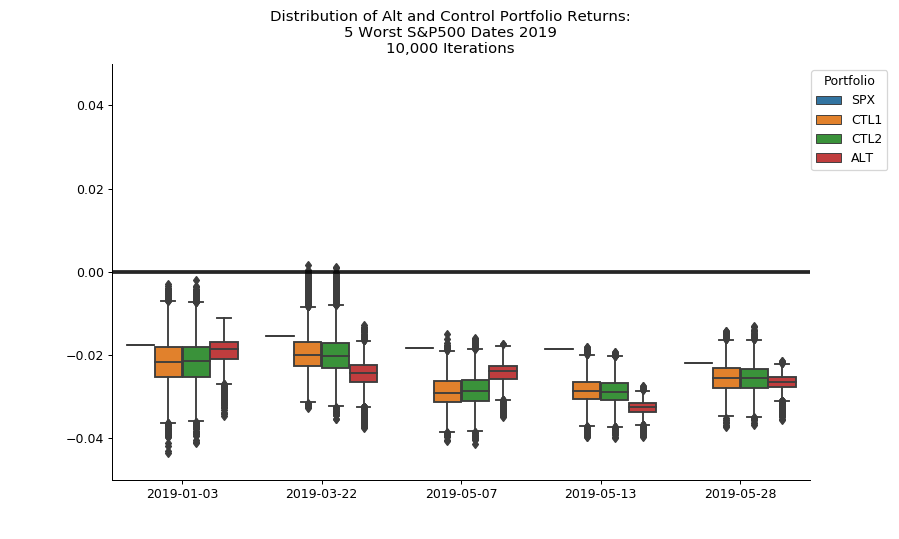

<IPython.core.display.Javascript object>


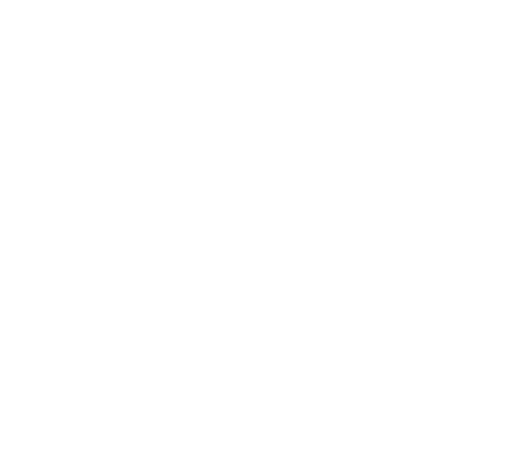

In [27]:
plot_boxplots(experiment_df)

In [26]:
def plot_boxplots(df):
    fig, ax = plt.subplots(figsize=(10,6))
    
    temp_df = df.iloc[:, :-1]
    melted_df = pd.melt(df,id_vars=['date'], value_vars=['SPX', 'CTL1', 'CTL2', 'ALT'],
                var_name = 'portfolio', value_name='returns')

    g = sns.catplot(ax=ax, data=melted_df, kind='box', x='date', y='returns', hue='portfolio', legend=True, legend_out=True)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')        

    #ax.set_title('Samples={}, P_Size={}'.format(sample_size, p_size), fontsize=20)
    ax.set_xticklabels(['2019-01-03', '2019-03-22', '2019-05-07', '2019-05-13', '2019-05-28'])
    ax.tick_params(axis="x", rotation=0)
    #ax.axhline(return_sp19, color='red', alpha=0.7, label='SP500 2019/2020')
    #ax.axhline(return_sp20, color='red', alpha=0.7)
    ax.axhline(0, color='black', alpha=0.85, linewidth=3)
    ax.set_ylim(-0.05, 0.05)

    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.12,1), title='Portfolio', fontsize=10)
    legend.get_title().set_fontsize('10')

    fig.suptitle('Distribution of Alt and Control Portfolio Returns:\n5 Worst S&P500 Dates 2019\n{:,} Iterations'.format(n_loops))
    #fig.text(0.5, 0.04, 'R Threshold', ha='center', va='center', fontsize=15)
    #fig.text(0.06, 0.5, 'Portfolio Return', ha='center', va='center', rotation=90, fontsize=15)
    fig.subplots_adjust(hspace=0.5)
    #plt.tight_layout()
    plt.close()
    plt.show()